In [27]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import time
import math

% matplotlib inline

### $d\theta_t = N(\alpha * \delta C_{t \bot}, K) + \beta_t U(0,2\pi)$

### $\beta_t =
  \begin{cases}
    1       & p\\
    0       & 1-p
  \end{cases}
$
### $p = \frac{1}{1+e^{-w^T\delta C_t}}$

### $\delta C = C_{t} - C_{t-1}$  $\text( parallel)$

### $\delta C = C_{t \bot} - C_{t-1 \bot}$  $\text( perpendicular)$

### $Parameters = \{\alpha, K, w\}$ 

- Wheatervaning strength $\alpha$, random-walk noise $K$, and tumble activation function $w$

### $Data = \{ d\theta_t, \delta C_t, \delta C_{t \bot} \}$

Questions:
- stationary vs. non-stationary covariance
- switching random variables
- GP fitting

Idea:

$d\theta_t = \alpha \delta C_{t\bot} + \eta_K$

$\eta = N(0,K)$

Regression on $d\theta$-$\delta C_{t\bot}$ to find $\alpha$ and $K$

Cluster $d\theta$ and fit for the activation function separately

In [28]:
#hybrid Gaussian process for angle time series
def d_theta(alpha, dc_perp, K, w, dC):
    '''
    Return change in theta angle for each step
    Input with alpha for weighting, dc for orthogonal concentration difference, and K covariance in weathervaning
    W as the weighting/kernel on concentration in the signoidal function for tumbling rate 
    '''
    wv = alpha*dc_perp + K*np.random.randn()  #weathervaning strategy
    P_event = 0.023/(0.4 + np.exp(140*dC/dt)) + 0.003  #sigmoidal function with parameters w
    if np.random.rand() < P_event:
        beta = 1
    else:
        beta = 0
    rt = beta*np.random.rand()*360 #(2*np.pi)  #run-and-tumble strategy
    dth = wv + rt
    return dth

In [29]:
#gradient environment
dis2targ = 50
C0 = 0.2
D = 0.000015
duT = 60*60*1
d = 0.18
def gradient(C0,x,y):
    concentration = C0/(4*np.pi*d*D*duT)*np.exp(-(x-dis2targ)**2/(400*D*duT*50))  #depends on diffusion conditions
    return concentration

In [30]:
#measure for concentration difference for weathervane
def dc_measure(dxy,xx,yy):
    perp_dir = np.array([-dxy[1], dxy[0]])
    perp_dir = perp_dir/np.linalg.norm(perp_dir)
    perp_dC = gradient(C0, xx+perp_dir[0], yy+perp_dir[1]) - gradient(C0, xx-perp_dir[0], yy-perp_dir[1])
    return perp_dC

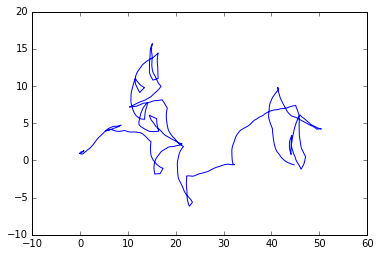

In [31]:
alpha = 25  #strength of OU forcing
K = 5  #covariance of weathervane
w = 0  #logistic parameter (default for now)
T = 3000
dt = 0.6  #seconds
v_m = 0.12  #mm/s
v_s = 0.01  #std of speed
time = np.arange(0,T*dt,dt)
xs = np.zeros(time.shape)
ys = np.zeros(time.shape)  #2D location
xs[0] = np.random.randn()
ys[0] = np.random.randn()
ths = np.zeros(time.shape)  #agle with 1,0
ths[0] = np.random.randn()
dxy = np.random.randn(2)

#with turning (Brownian-like tragectories)
for t in range(1,len(time)):
    
    #concentration = gradient(C0,xs[t-1],ys[t-1])
    dC = gradient(C0, xs[t-1],ys[t-1]) - gradient(C0, xs[t-2],ys[t-2])
    dc_perp = dc_measure(dxy,xs[t-1],ys[t-1])      
    dth = d_theta(alpha, -dc_perp, K, 0, dC)
    ths[t] = ths[t-1] + dth*dt
    
    e1 = np.array([1,0])
    vec = np.array([xs[t-1],ys[t-1]])
    theta = math.acos(np.clip(np.dot(vec,e1)/np.linalg.norm(vec)/np.linalg.norm(e1), -1, 1)) #current orienation relative to (1,0)

    vv = v_m + v_s*np.random.randn()
    dd = np.array([vv*np.sin(ths[t]*np.pi/180), vv*np.cos(ths[t]*np.pi/180)])  #displacement
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c,s), (-s, c)))  #rotation matrix, changing coordinates
    dxy = np.dot(R,dd)
    
    xs[t] = xs[t-1] + dxy[0]*dt
    ys[t] = ys[t-1] + dxy[1]*dt

    
#plt.plot(ths)
plt.figure()
plt.plot(xs,ys)

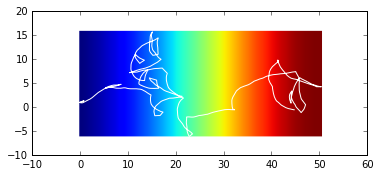

In [33]:
x = np.arange(np.min(xs),np.max(xs),1)
xx_grad = C0/(4*np.pi*d*D*duT)*np.exp(-(x-dis2targ)**2/(400*D*duT*50))
plt.imshow(np.expand_dims(xx_grad,axis=1).T,extent=[np.min(xs),np.max(xs),np.min(ys),np.max(ys)])
plt.hold(True)
plt.plot(xs,ys,'white')

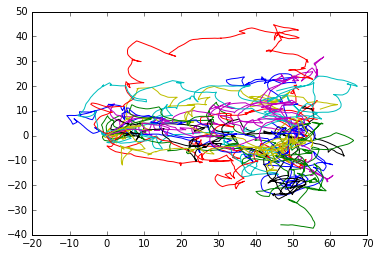

In [34]:
all_dc = []
all_th = []
for ii in range(20):
    xs = np.zeros(time.shape)
    ys = np.zeros(time.shape)  #2D location
    xs[0] = np.random.randn()*0.1
    ys[0] = np.random.randn()*0.1
    ths = np.zeros(time.shape)  #agle with 1,0
    ths[0] = np.random.rand()*0
    dcs = np.zeros(time.shape)
    dths = np.zeros(time.shape)
    for t in range(1,len(time)):
        
        dC = gradient(C0, xs[t-1],ys[t-1]) - gradient(C0, xs[t-2],ys[t-2])
        dc_perp = dc_measure(dxy,xs[t-1],ys[t-1])      
        dth = d_theta(alpha, -dc_perp, K, 0, dC)
        ths[t] = ths[t-1] + dth*dt
        
        dcs[t] = dc_perp
        dths[t] = dth
        
        e1 = np.array([1,0])
        vec = np.array([xs[t-1],ys[t-1]])
        theta = math.acos(np.clip(np.dot(vec,e1)/np.linalg.norm(vec)/np.linalg.norm(e1), -1, 1)) #current orienation relative to (1,0)

        vv = v_m + v_s*np.random.randn()
        dd = np.array([vv*np.sin(ths[t]*np.pi/180), vv*np.cos(ths[t]*np.pi/180)])  #displacement
        c, s = np.cos(theta), np.sin(theta)
        R = np.array(((c,s), (-s, c)))  #rotation matrix, changing coordinates
        dxy = np.dot(R,dd)

        xs[t] = xs[t-1] + dxy[0]*dt
        ys[t] = ys[t-1] + dxy[1]*dt
        
    all_dc.append(dcs)  #recording dC
    all_th.append(dths)  #recording head angle
        
    plt.plot(xs,ys)
    plt.hold(True)

## GP fitting

In [ ]:
# dsamp = 100
# from scipy import signal
# data_th = signal.resample(all_th, dsamp);
# data_dc = signal.resample(all_dc, dsamp);

In [35]:
data_th = np.array(all_th)
data_dc = np.array(all_dc)

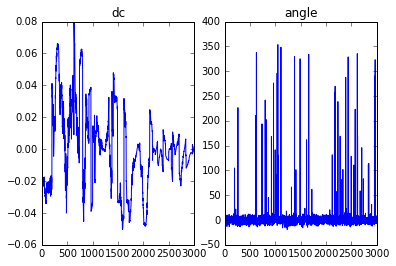

In [42]:
tr = 0
plt.subplot(1,2,1)
plt.title('dc')
plt.plot(data_dc[tr,:])
plt.subplot(1,2,2)
plt.title('angle')
plt.plot(data_th[tr,:])

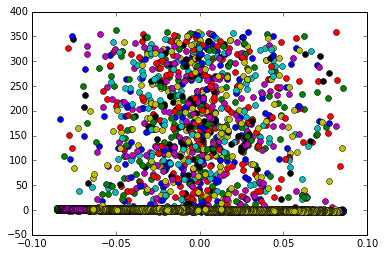

In [9]:
#dc vs. dtheta
plt.plot(data_dc.T, data_th.T, 'o');

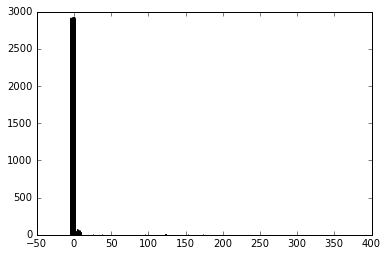

In [10]:
#distribution of angles
plt.hist(data_th.T, bins=50);

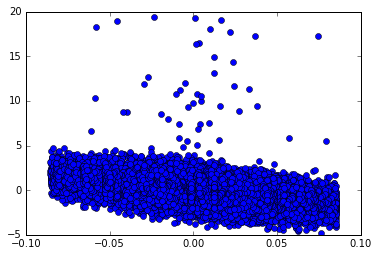

In [11]:
#GP regression for weathervane
data_wv = data_th[data_th<20]  #.copy()
data_dc_wv = data_dc[data_th<20]
#data_wv[data_wv>30] = 20
plt.plot(data_dc_wv.T, data_wv.T, 'o');

In [16]:
#sub-sampling first
data_dc_wv = data_dc_wv[data_dc_wv.argsort()]
data_dc = data_dc_wv[data_dc_wv.argsort()]

dsamp = 500
from scipy import signal
sub_dc = signal.resample(data_dc_wv, dsamp);
sub_dth = signal.resample(data_wv, dsamp);

/Users/Macintosh/anaconda/lib/python3.5/site-packages/scipy/signal/signaltools.py:2223: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/Users/Macintosh/anaconda/lib/python3.5/site-packages/scipy/signal/signaltools.py:2225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/Users/Macintosh/anaconda/lib/python3.5/site-packages/scipy/signal/signaltools.py:2230: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be i

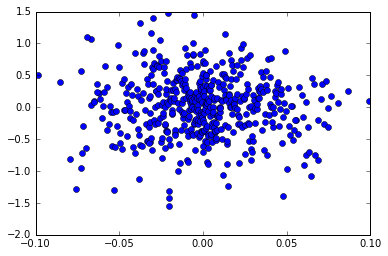

In [20]:
plt.plot(sub_dc, sub_dth, 'o')

In [21]:
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF

In [22]:
### GP Regression
gp = gaussian_process.GaussianProcessRegressor(kernel = RBF(length_scale=5)) #kernel_exp(kernel_RBF, 1))
gp.fit(np.expand_dims(sub_dc, axis=1), np.expand_dims(sub_dth, axis=1))

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=RBF(length_scale=5), n_restarts_optimizer=0,
             normalize_y=False, optimizer='fmin_l_bfgs_b',
             random_state=None)

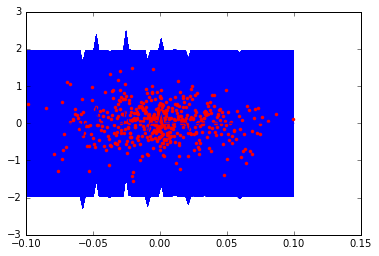

In [26]:
xx = np.linspace(-0.1,0.1,100)
y_pred, sigma = gp.predict(np.expand_dims(xx,axis=1), return_std=True)

plt.figure()
plt.plot(sub_dc, sub_dth, 'r.', label='data')
plt.plot(xx, y_pred, 'b-', label='prediction')
plt.fill(np.concatenate([xx, xx[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
#plt.legend(loc='upper left')